In [42]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Carregamento dos Dados

Carrega os dados do arquivo *Data.csv* e exibe as primeiras linhas do DataFrame.

In [43]:
df = pd.read_csv('Modelo\\Data.csv')

df.head()

,QT_VOTOS,VR_DESPESA_CONTRATADA
0,1125,213127.50
1,27393,3016571.30
2,771,99998.00
3,242100,4077998.59
4,103265,2462596.06


# Normalização e Remoção de Outliers

Normaliza as colunas *VR_DESPESA_CONTRATADA* e *QT_VOTOS* usando **StandardScaler** e remove outliers do DataFrame usando o método do intervalo interquartil (IQR).

In [44]:
scaler = StandardScaler()
df[['VR_DESPESA_CONTRATADA', 'QT_VOTOS']] = scaler.fit_transform(df[['VR_DESPESA_CONTRATADA', 'QT_VOTOS']])

df.head()

,QT_VOTOS,VR_DESPESA_CONTRATADA
0,-0.346311,-0.676544
1,-0.335648,-0.206300
2,-0.346455,-0.695520
3,-0.248490,-0.028258
4,-0.304849,-0.299222


In [45]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

Além disso, cria um **gráfico de disperção** para a visualização da relação entre *VR_DESPESA_CONTRATADA* e *QT_VOTOS*

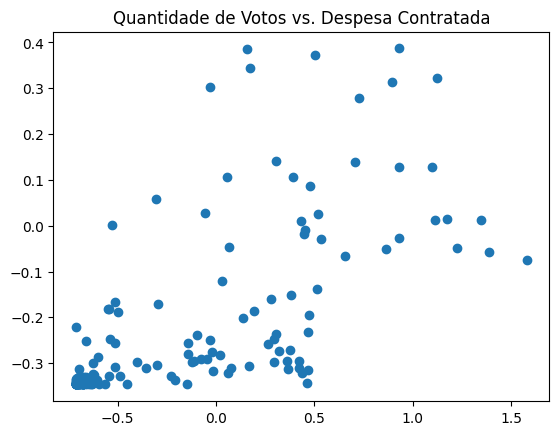

In [46]:
plt.scatter(x='VR_DESPESA_CONTRATADA', y='QT_VOTOS', data=df)
plt.title('Quantidade de Votos vs. Despesa Contratada')
plt.show()

# Construção e Avaliação do Modelo

Constrói um modelo de regressão usando **Comite de Modelos** com *LinearRegression* e *RandomForest*. Avalia o modelo usando **validação cruzada** e calcula os erros quadráticos médios (RMSE) e erros absolutos médios (MAE).

In [47]:
X = df.drop('QT_VOTOS', axis=1)
y = df['QT_VOTOS']

In [48]:
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

ensemble_model = VotingRegressor(estimators=[
    ('lr', linear_model),
    ('rf', rf_model)
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(ensemble_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

cv_mae = cross_val_score(ensemble_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
cv_mae = -cv_mae

print(f"Cross Validation RMSE Scores: {cv_scores}")
print(f"Mean Cross Validation RMSE: {cv_scores.mean()}")
print(f"Standard Deviation of Cross Validation RMSE: {cv_scores.std()}")

print(f"\nCross Validation MAE Scores: {cv_mae}")
print(f"Mean Cross Validation MAE: {cv_mae.mean()}")
print(f"Standard Deviation of Cross Validation MAE: {cv_mae.std()}")

ensemble_model.fit(X, y)
y_pred = ensemble_model.predict(X)

Cross Validation RMSE Scores: [-0.01593643 -0.01015402 -0.02462146 -0.01277374 -0.01643536]
Mean Cross Validation RMSE: -0.015984203079973735
Standard Deviation of Cross Validation RMSE: 0.004880698791427802

Cross Validation MAE Scores: [0.06564376 0.06685061 0.08903228 0.0713279  0.08212967]
Mean Cross Validation MAE: 0.07499684488705381
Standard Deviation of Cross Validation MAE: 0.009112333009564341


# Avaliação dos resultados preditos

Calcula e imprime o erro absoluto médio (MAE) e o erro quadrático médio (RMSE) do modelo. Também, cria um gráfico de dispersão para visualizar a relação entre os valores reais e preditos pelo modelo.

In [49]:
mae = mean_absolute_error(y, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

rmse = mean_squared_error(y, y_pred)
rmse = np.sqrt(rmse)    
print(f"Mean Absolute Error (rmse): {rmse}")

Mean Absolute Error (MAE): 0.05287565106270379
Mean Absolute Error (rmse): 0.08799387533732018


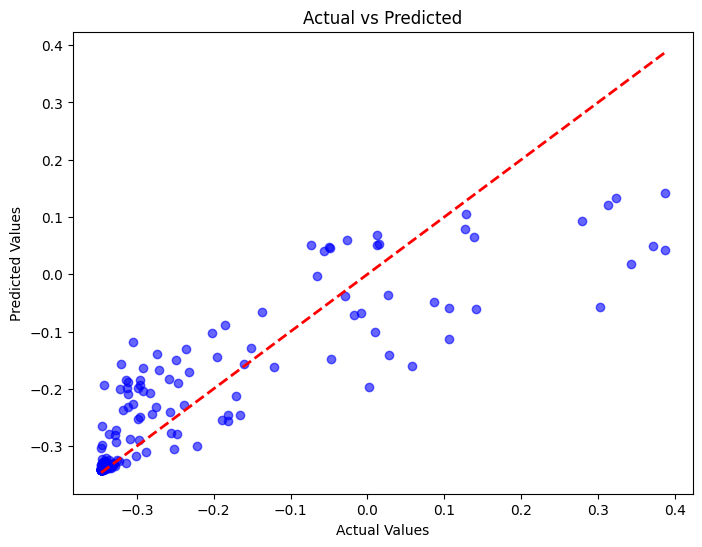

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.6, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

# Predição para Novos Dados

Cria um DataFrame com novos dados (vindo de eleições passadas), normaliza esses dados, faz predições usando o modelo treinado e visualiza as predições em um gráfico de barras.

c:\Users\Cliente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Cliente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


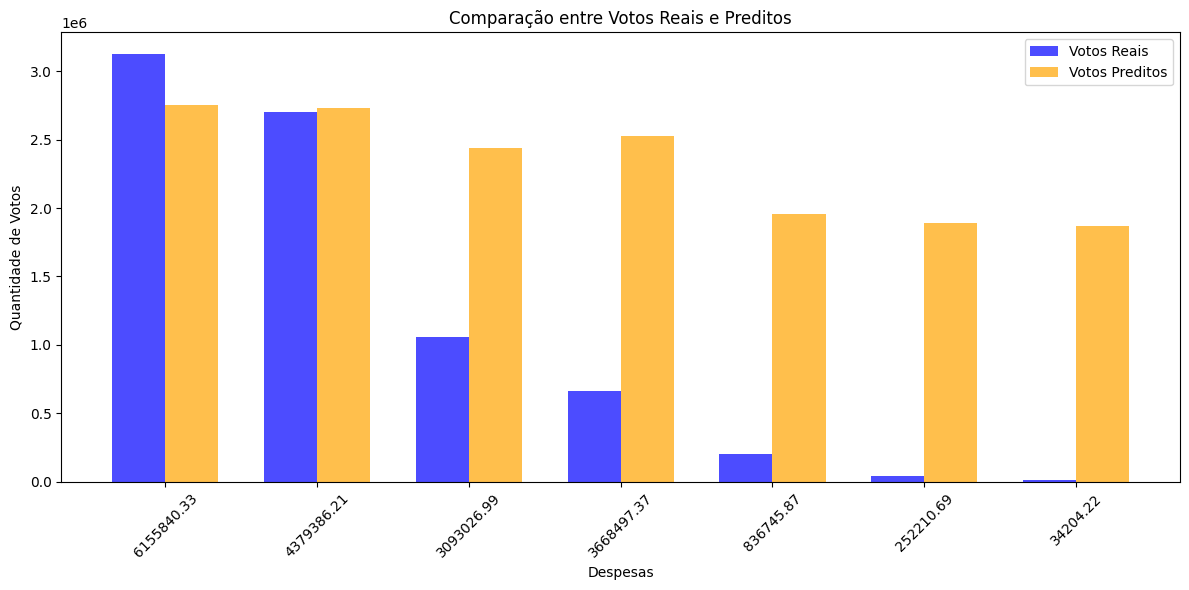

In [52]:
votos_reais = [3128317, 2705601, 1060209, 661717, 200877, 37993, 8917]
despesas = [6155840.33, 4379386.21, 3093026.99, 3668497.37, 836745.87, 252210.69, 34204.22]

df_teste = pd.DataFrame({
    'Despesa': despesas,
})
df_teste = scaler.fit_transform(df_teste)

votos_preditos = ensemble_model.predict(df_teste)
votos_preditos = scaler.inverse_transform(votos_preditos.reshape(-1, 1)).flatten()

df_teste = pd.DataFrame({
    'Despesa': despesas,
    'Votos Reais': votos_reais,
    'Votos Preditos': votos_preditos
})

plt.figure(figsize=(12, 6))
x = np.arange(len(df_teste))
width = 0.35

plt.bar(x - width/2, df_teste['Votos Reais'], width, label='Votos Reais', color='blue', alpha=0.7)
plt.bar(x + width/2, df_teste['Votos Preditos'], width, label='Votos Preditos', color='orange', alpha=0.7)

plt.xlabel('Despesas')
plt.ylabel('Quantidade de Votos')
plt.title('Comparação entre Votos Reais e Preditos')
plt.xticks(x, labels=[f"{d}" for d in despesas], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()